# Classification Modeling

### We finally have our final datasets for training/testing the Classification model!

The final_df_2017 and final_df_2019 datasets contain MUNI stops and their corresponding neighborhood's demographic information.
- The column 'ESN' tells us whether that stop is located in a city-designated Equity Strategy Neighborhood.
- If the ESN value is 0, the stop is not located in an ESN neighborhood. 
- If the ESN value is 1, it is located in an ESN neighborhood.

Let's use the final_df_2017 dataset to train a cluster model. Then, let's test the model using our final_df_2019 dataset.

The cluster model will be trained to identify which stops are located in ESN neighborhoods based on the 2017 demographic data for each SF MUNI stop. The model will then attempt to cluster the 2019 stops as either in/not in an ESN neighborhood based on their demographic data.

In [1]:
# cleaning the data set 
import pandas as pd
final_df_2017 = pd.read_csv('Data/final_df_2017.csv')
final_df_2019 = pd.read_csv('Data/final_df_2019.csv')

final_df_2017.drop('Unnamed: 0', axis=1, inplace=True)
final_df_2019.drop('Unnamed: 0', axis=1, inplace=True)

# setting data type as int inorder to avoid it being convert into categorical data
final_df_2019['year_collected'] = final_df_2019['year_collected'].astype(int)
final_df_2017['year_collected'] = final_df_2017['year_collected'].astype(int)

In [2]:
# general function for model performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

def modelperformance(modelname, y_test, y_pred):
    print("\n", "------------------- ", modelname, "Performance -------------------","\n")
    print('Accuracy Score = ',accuracy_score(y_test, y_pred))  
    print("\n", 'Confusion Matrix')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [33]:
# general function to plot top_n features from a model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def featureimp(rf, x, top=10):
    importances = rf.feature_importances_
    forest_importances = pd.Series(importances, index=x.columns)

    # get the standard deviations to be able to plot the error bars
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    # sort the importances in descending order
    forest_importances.sort_values(inplace=True, ascending=False)


    num_features = 10  # Specify the desired number here

    # Subset the top N feature importances
    top_n_importances = forest_importances[:num_features]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=top_n_importances.values, y=top_n_importances.index, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    return (top_n_importances)
    # Create a bar plot for the top N feature importances


2017 Training Model: Predicted fraction True: 0.1677. Actual fraction True: 0.1677 


 -------------------  Training model Performance ------------------- 

Accuracy Score =  1.0

 Confusion Matrix


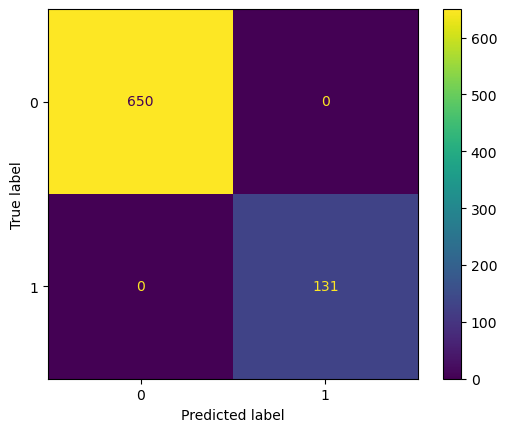

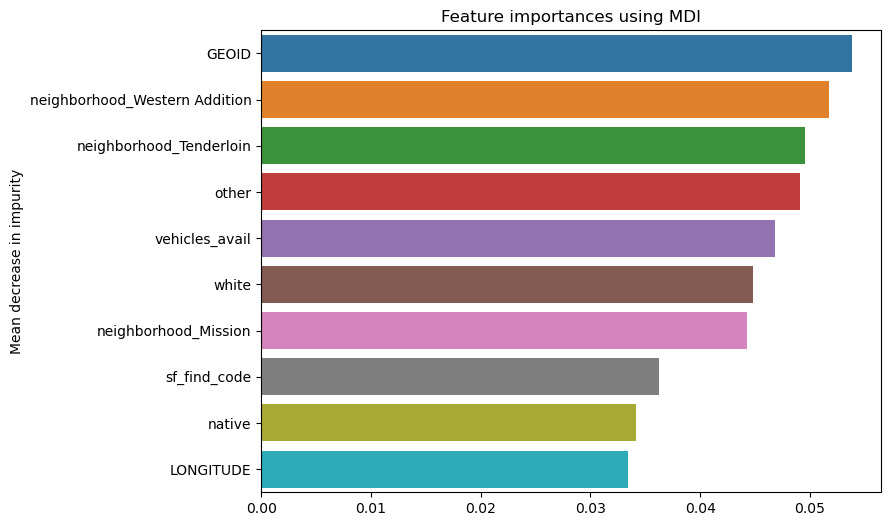

In [35]:
# ML model on 2017 data alone 

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

cols =  ['neighborhood', 'GEOID', 'total pop', 'white', 'black', 'native', 'asian',
         'hawaiian/pac islander', 'other', 'median_hh_income', 'vehicles_avail',
         'OBJECTID', 'STOPNAME', 'TRAPEZESTOPABBR', 'RUCUSSTOPABBR', 'STOPID',
         'LATITUDE', 'LONGITUDE', 'ACCESSIBILITYMASK', 'ATSTREET', 'ONSTREET',
         'POSITION', 'ORIENTATION', 'SDE_ID', 'SIGNUPID','sf_find_code',
         'analysis_neigh_code', 'ESN','year_collected']


# Converting string objects into categorical variables inorder to enable the classificaiton model work 
cluster_2017 = pd.get_dummies(final_df_2017[cols]).dropna()
    

# defining features and predicted variable
xvars = cluster_2017.drop('ESN', axis=1)
yvar = cluster_2017['ESN']


# train-test split on the data
X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(xvars, 
                                                                        yvar, 
                                                                        test_size = 0.25, 
                                                                        random_state = 1)

# random forest classification and prediction
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# Training the model
rf.fit(X_train_2017, y_train_2017)

# predicting the target variable
y_pred_2017 = rf.predict(X_test_2017)

print('2017 Training Model: Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred_2017.mean(), y_test_2017.mean()), "\n")
modelperformance("Training model", y_test_2017, y_pred_2017)

x = featureimp(rf, X_train_2017, 5)


#### 2017 Model Results
The training model has a very high accuracy score. We can see from the confusion matrix that it correctly identifies 656 observations as negative, and 115 as positive. While this high score could be due to overfitting as the dataset is quite small - a little over 3000 variables it more likely the case that the variables selected are  accurate in determining the ENS

Let us now train the model entirely with 2017 data and predict for 2019 data. We make two models.

* Model 1: With string features transformed into categorical variables
* Model 2: With only numerical features retained, and transfomed to fit better. 

### Model 1
Model 1: With string features transformed into categorical variables

In [5]:
# Function to cleaning the data set to retain. only relavant features, that are appropriate categorical/numerical . 

def dataset_preparation(df1, df2, cols):

    # preserving only relevant features 
    cluster_2019 = df1[cols]
    cluster_2017 = df2[cols]

    # In order to maintain consitency in both the datasets, a concatenated dataframe is created which is cleaned, then seperated out later
    concatenated_df = pd.concat([cluster_2019, cluster_2017])

    # cleaning the index
    concatenated_df = concatenated_df.reset_index(drop=True)

    # Converting string objects into categorical variables inorder to enable the classificaiton model work 
    concatenated_df = pd.get_dummies(concatenated_df)

    # regenerating 2019 and 2017 data sets seperately. 
    cluster_2019_final = concatenated_df[concatenated_df['year_collected'] == 2019]
    cluster_2017_final = concatenated_df[concatenated_df['year_collected'] == 2017]
    
    #retuning the cleaned dataset for classification
    print("------------------- Dataset Cleaned Successfully -------------------")
    return (cluster_2019_final, cluster_2019_final)


In [29]:
def training_model(df_to_fit, df_to_predict):
    rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
    # rf = DecisionTreeClassifier(random_state = 1)
    df_to_fit=df_to_fit.dropna()
    df_to_predict=df_to_predict.dropna()
    xvars_2017 = df_to_fit.drop('ESN', axis=1)
    yvars_2017 = df_to_fit['ESN']
    xvars_2019 = df_to_predict.drop('ESN', axis=1)
    yvars_2019 = df_to_predict['ESN']

    # now fit the model
    rf.fit(xvars_2017, yvars_2017)

    print("\n", "------------------- Model Trained Successfully -------------------","\n")
    
    # predicting the target variable
    y_predit_2019 = rf.predict(xvars_2019)

    # print('2017 Training Model: Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred_2017.mean(), y_pred_2017.mean()), "\n")
    modelperformance("Prediction", y_predit_2019, yvars_2019)
    featureimp(rf, xvars_2019)
    return (rf)

------------------- Dataset Cleaned Successfully -------------------

 ------------------- Model Trained Successfully ------------------- 


 -------------------  Prediction Performance ------------------- 

Accuracy Score =  1.0

 Confusion Matrix


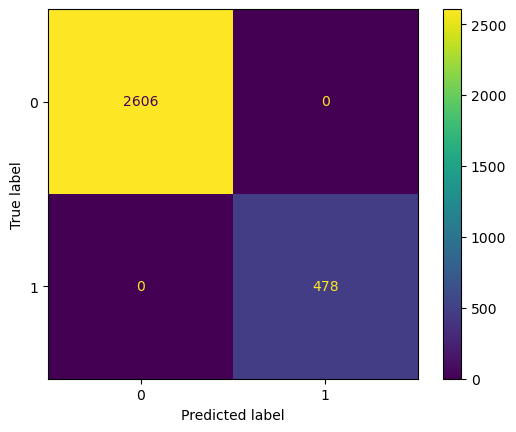

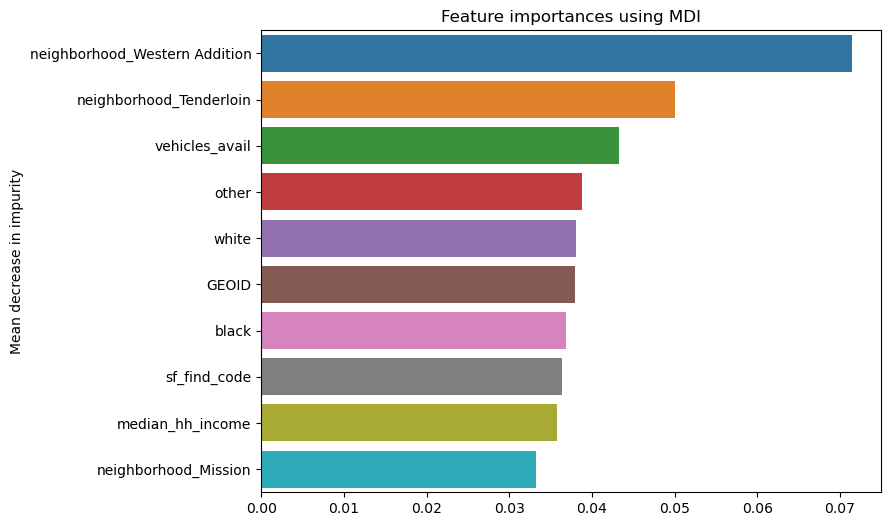

In [36]:
# Implementing Model 1

# Columns Preserved (geometry and polygons are removed)
cols =    ['neighborhood', 'GEOID', 'total pop', 'white', 'black', 'native', 'asian',
                         'hawaiian/pac islander', 'other', 'median_hh_income', 'vehicles_avail',
                         'OBJECTID', 'STOPNAME', 'TRAPEZESTOPABBR', 'RUCUSSTOPABBR', 'STOPID',
                         'LATITUDE', 'LONGITUDE', 'ACCESSIBILITYMASK', 'ATSTREET', 'ONSTREET',
                         'POSITION', 'ORIENTATION', 'SDE_ID', 'SIGNUPID','sf_find_code', 
                         'analysis_neigh_code', 'ESN','year_collected']


#function call transform all features to either categorical or numerical 
cluster_2019_final, cluster_2017_final = dataset_preparation(final_df_2019, final_df_2017, cols)
cluster_2019_final.head()

# preparing x and y variables and dopping null values

rf_m1 = training_model(cluster_2017_final, cluster_2019_final)

### Model 1 Results
We find that this model perfeclty predicts if the 2019 stops are in ESN or not, as seen in the perfect accuracy score. We can see from the confusion matrix that it correctly identifies 2606 observations as negative, and 478 as positive. 

While this high score could be due to overfitting due to following reasons: the presence of neighbourhood categorical variables is distorting the resutls, as this is perfectly correlated to ESN designation.

Hence this result is spurious and it tells little about if the ENS designation continue to be appropriate in 2019. Hence we implement the second model. 


# Model 2

Model 2 attemts to retain only census dataset variables that are likely to change over the two years. We also transform with an imputer to transform any missing/nan variables as per the trends in the dataset. 


 -------------------  Prediction for 2019 Performance ------------------- 

Accuracy Score =  0.973113351665139

 Confusion Matrix


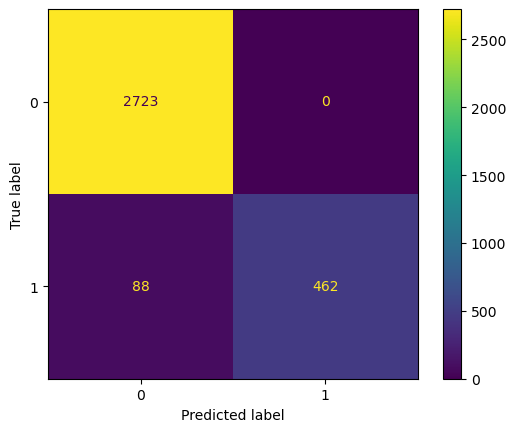

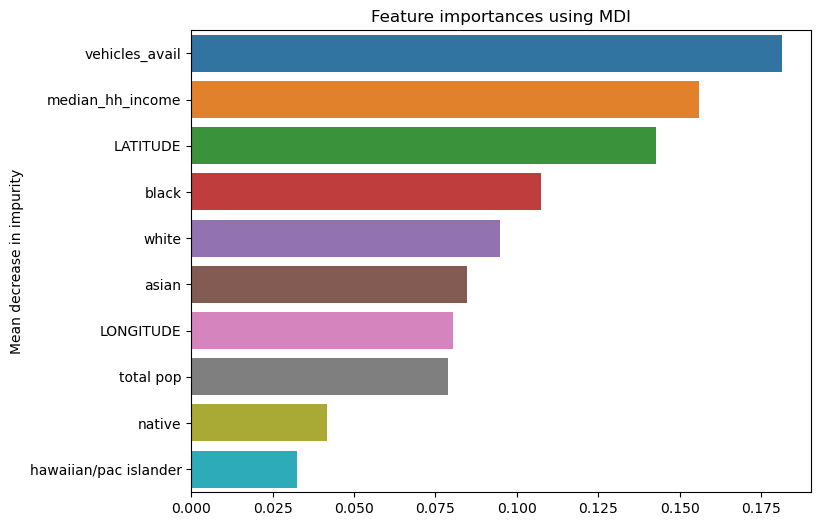

In [39]:
# Model 2
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier 
# initialiting the imputer
imputer = KNNImputer()
# Columns Preserved
# Ensuring all data numerical (geometry and polygons are removed)
xvars =    ['total pop', 'white', 'black', 'native', 'asian','hawaiian/pac islander', 'median_hh_income', 'vehicles_avail',
                         'LATITUDE', 'LONGITUDE']

yvar = 'ESN'

X_2017 = imputer.fit_transform(final_df_2017[xvars])
Y_2017 = final_df_2017[yvar]
X_2019 = imputer.transform(final_df_2019[xvars])
Y_2019 = final_df_2019[yvar]


# Initialize the Random Forest Classifier
rf_m2 = RandomForestClassifier(n_estimators=50, random_state=1)

# Train the model on the 2017 data
rf_m2.fit(X_2017, Y_2017)

# Predict the 'ESN' variable for the 2019 data
y_pred_2019 = rf_m2.predict(X_2019)

modelperformance("Prediction for 2019", Y_2019, y_pred_2019)
x = featureimp(rf_m2, final_df_2017[xvars], 5)


### Model 2 Results
We find that this model has high accuracy, but it is less than perfect. It correctly identified identifies 2723 observations as negative, and 462 as positive, but classifies 88 as non-ENS despite them being ESN. This might indicate that 88 neighbourhoods that in 2017 has high needs (as defined by the variables) have improved in the two years and now come above the ESN theshold. 

Since no real non-ENS neighbourhoods have been identified as ESN, we can conclude that the exisiting strategy need is sufficent to serve all neighbourhoods that have a need. 
  


In [15]:
X_2019

array([[ 507.      ,   28.      ,  114.      , ...,  125.      ,
          37.7382  , -122.450884],
       [ 507.      ,   28.      ,  114.      , ...,  125.      ,
          37.734345, -122.448776],
       [ 507.      ,   28.      ,  114.      , ...,  125.      ,
          37.740975, -122.449223],
       ...,
       [3429.      , 1311.      ,   64.      , ...,  764.      ,
          37.794998, -122.42125 ],
       [3429.      , 1311.      ,   64.      , ...,  764.      ,
          37.796185, -122.421731],
       [3429.      , 1311.      ,   64.      , ...,  764.      ,
          37.791741, -122.420827]])

# Plotting Map

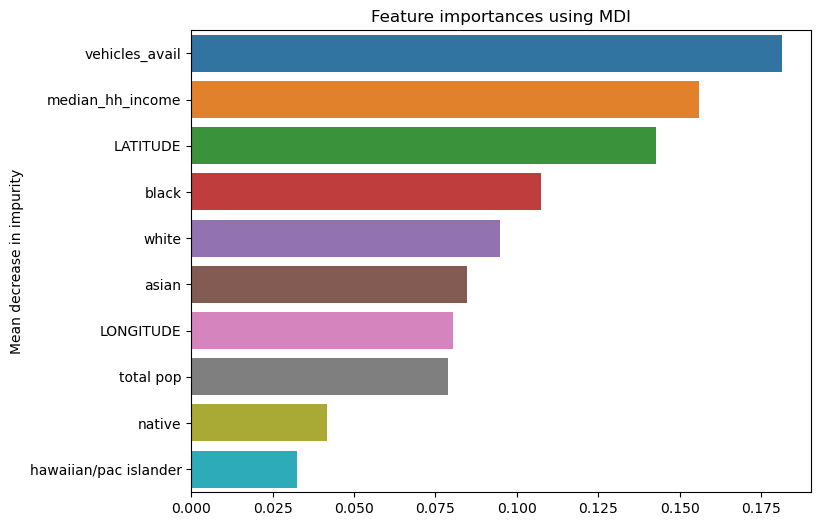

In [24]:
# Comparing Predictions for 2019 with actual 2019 Values
predictions = pd.DataFrame(rf_m1.predict_proba(final_df_2019[xvars]).columns = ['pred_noESN', 'pred_ESN'])
predictions.head()
predictions= predictions.join(final_df_2019[xvars]).reset_index()
predictions.head()

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (4165891092.py, line 2)

In [67]:
import geopandas as gpd
predictions = gpd.GeoDataFrame(predictions, 
                    geometry = gpd.points_from_xy(
                        predictions.LONGITUDE,
                        predictions.LATITUDE, crs='EPSG:4326'))

In [ ]:
cluster_2019_final

In [85]:
cluster_2019_final = gpd.GeoDataFrame(cluster_2019_final, 
                    geometry = gpd.points_from_xy(
                        cluster_2019_final.LONGITUDE,
                        cluster_2019_final.LATITUDE, crs='EPSG:4326'))

[]

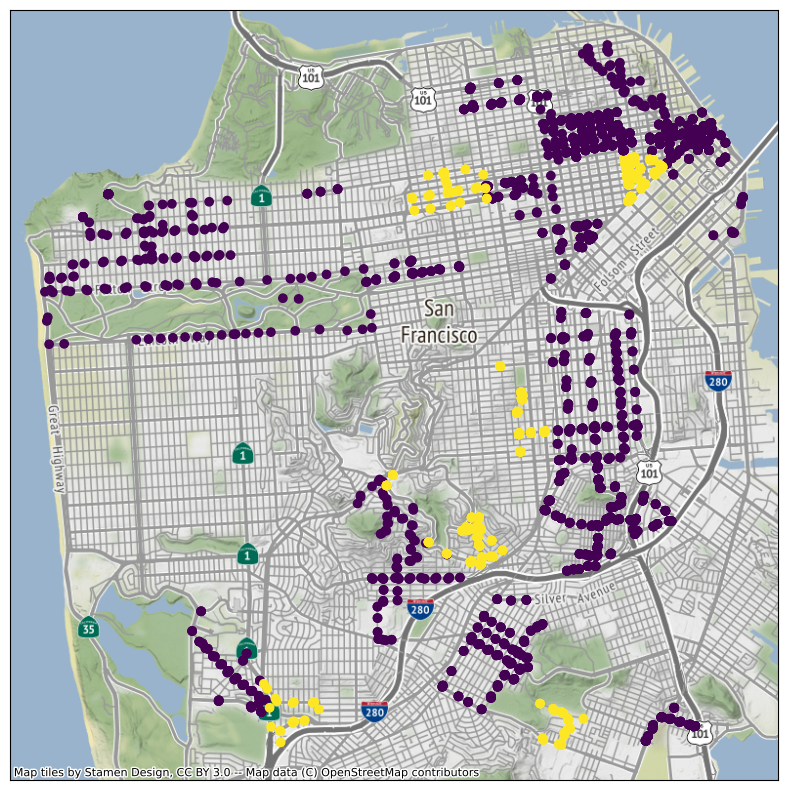

In [86]:
import contextily as ctx
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
cluster_2019_final.to_crs('EPSG:3857').plot('ESN', ax=ax)
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

[]

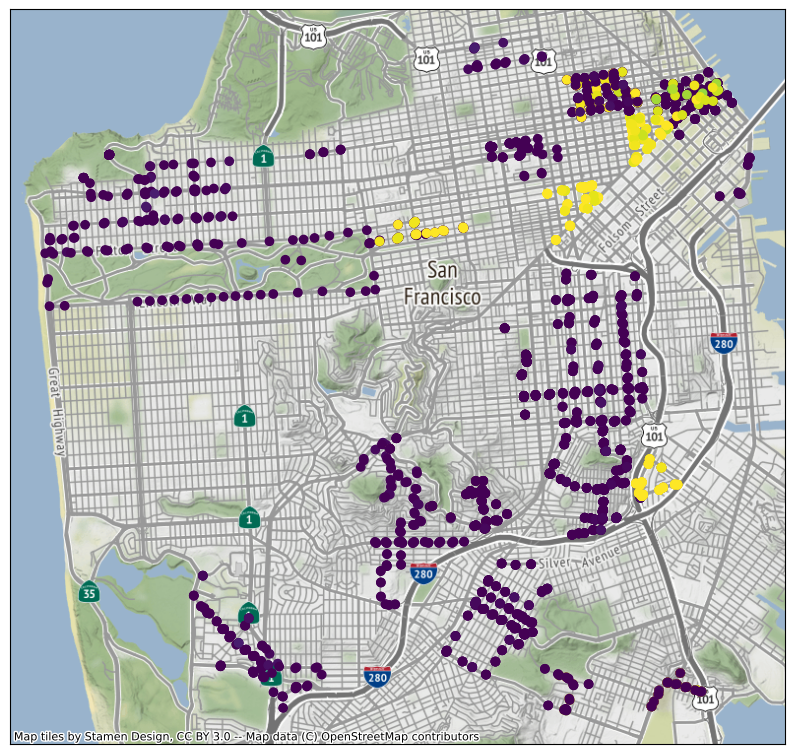

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
predictions.to_crs('EPSG:3857').plot('pred_ESN', ax=ax)
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

[]

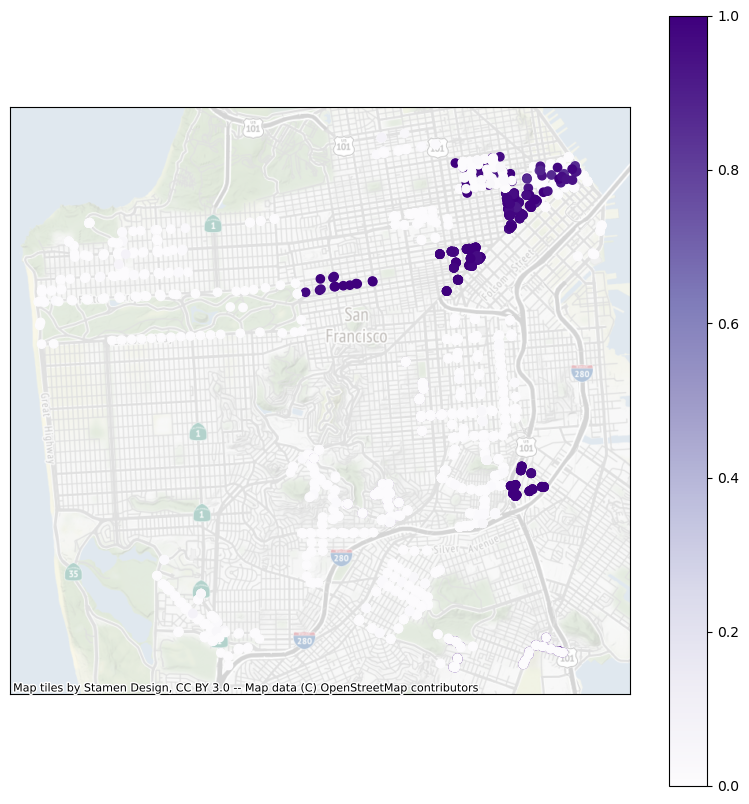

In [90]:
fig, ax = plt.subplots(figsize=(10,10))
predictions.to_crs('EPSG:3857').plot('pred_ESN', cmap='Purples', 
                                                               ax=ax, legend=True)
ctx.add_basemap(ax=ax, alpha = 0.3)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
predictions[predictions.pred_ESN>0.1].to_crs('EPSG:3857').plot('pred_ESN', cmap='Purples', 
                                                               ax=ax, legend=True)
ctx.add_basemap(ax=ax, alpha = 0.3)
ax.set_xticks([])
ax.set_yticks([])

# Discussion

Accuracy Score: 1.0000


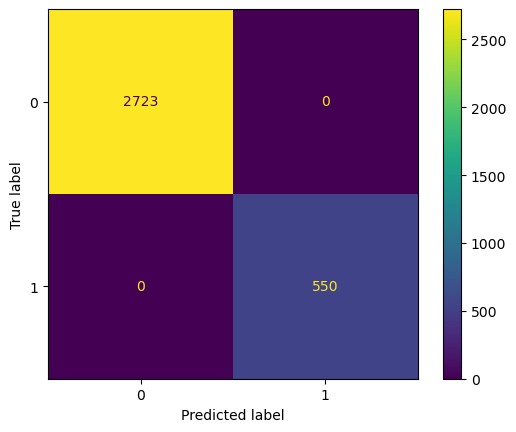

In [44]:
# # Training the Model with 2017 data set 
# # we implement a train-text model within here to understand how well the model is performing with respect to the 2017 (known) data

# from sklearn.model_selection import train_test_split



# # declaring all variables but ESN as x variables value



# xvars = cluster_2017_final
# xvars = xvars.drop('ESN', axis=1)
# yvar = cluster_2017_final['ESN']

# xvars = xvars.dropna()
# X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(xvars, yvar, test_size = 0.25, random_state = 1)


# # random forest classification and prediction
# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.tree import DecisionTreeClassifier 

# rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
# # rf = DecisionTreeClassifier(random_state = 1)

# # now fit the model
# rf.fit(X_train_2017, y_train_2017)

# # predicting the target variable
# y_pred_2017 = rf.predict(X_test_2017)

# print('2017 Data: Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred_2017.mean(), y_test_2017.mean()))


#### Prediction Results
The prediction also has a very high accuracy score. We can see from the confusion matrix that it correctly identifies 2723 observations as negative, and 550 as positive as compared to the actual equity strategy neighbourhoods in 2019. 

A conclusion to be drawn from this is that we can very accurately predict the ESN in 2019 based on the 2017 data. This result is helpful in one way

#### Prediction Results
The prediction also has a very high accuracy score. We can see from the confusion matrix that it correctly identifies 682 observations as negative, and 137 as positive. While this high score could be due to overfitting as the dataset is quite small - a little over 3000 variables it more likely the case that the variables selected are  accurate in determining the ENS

Let us now predict for 2019 data. 
this says as per the older model, 0.1680 of the values must be ESN in 2019 

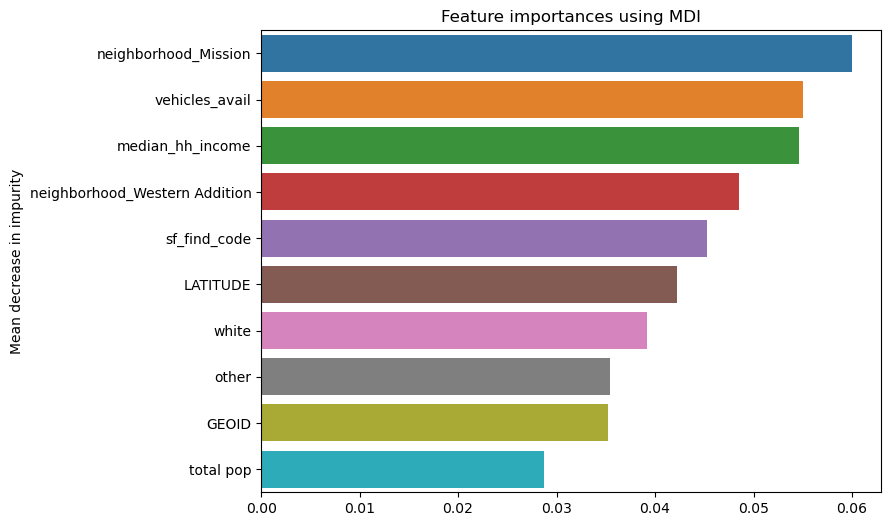

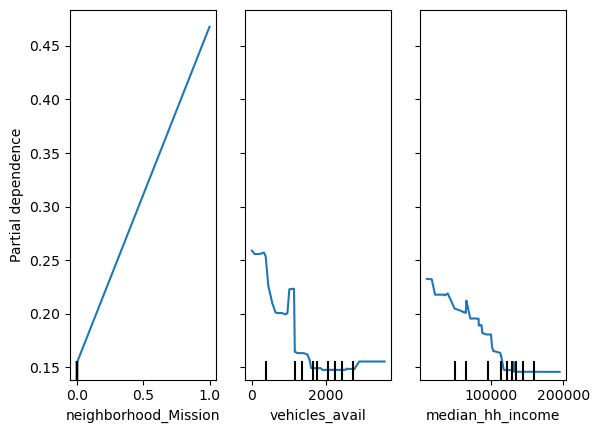

In [35]:
# feature importance
import numpy as np
import matplotlib.pyplot as plt
importances = rf.feature_importances_
import seaborn as sns

# convert to a series, and give the index labels from our X_train dataframe
forest_importances = pd.Series(importances, index=X_train_2017.columns)

# get the standard deviations to be able to plot the error bars
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# sort the importances in descending order
forest_importances.sort_values(inplace=True, ascending=False)


num_features = 10  # Specify the desired number here

# Subset the top N feature importances
top_n_importances = forest_importances[:num_features]

# Create a bar plot for the top N feature importances
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=top_n_importances.values, y=top_n_importances.index, ax=ax)


# fig, ax = plt.subplots(figsize=(4,2))
# sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# Partial dependency for the three variables

from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf, X_test_2017,
                                       forest_importances.index[:3])



### Why does this matter?

If the cluster model successfully clusters the same MUNI stops in 2019 (compared to 2017) as belonging to ESN neighborhoods, then we know that the conditions of ESN neighborhoods in SF have not improved enough for the stops in these neighborhoods to graduate from their ESN-designation. 

If the model does not successfully cluster the same MUNI stops in 2019 beloning to ESN neighborhoods based on 2019 data, then it's possible that the conditions of ESN neighborhoods (first measured in 2017) may have improved, and that the MUNI stops who were not classified as ESN

In [8]:
import cenpy
from cenpy import products
from sklearn.model_selection import train_test_split



def get_census(year):
    acs = cenpy.products.ACS()

    census = products.ACS(year).from_place('San Francisco, CA', level='tract',
                                            variables=['B19019_001E','B25046_001E'])
    census.rename(columns={'B19019_001E':'median_hh_income', 'B25046_001E':'vehicles_avail'}, inplace=True)



    race = products.ACS(year).from_place('San Francisco, CA', level='tract',
                                            variables='B02001')
    race.rename(columns={'B02001_001E':'total pop', 'B02001_002E':'white','B02001_003E':'black','B02001_004E':'native','B02001_005E':'asian','B02001_006E':'hawaiian/pac islander','B02001_007E':'other'}, inplace=True)

    race = race.drop(columns=['B02001_008E', 'B02001_009E','B02001_010E'])


    # Join race and census data.
    race['tract']=race['tract'].astype(int)
    census['tract']=census['tract'].astype(int)

    demographics = pd.merge(race, census, how='inner',
                      left_on=['tract', 'county', 'state', 'geometry', 'GEOID'],
                      right_on=['tract', 'county','state', 'geometry', 'GEOID'])

    # Cast nums as ints
    demographics['GEOID'] = demographics['GEOID'].astype(int)

    demographics['tract'] = demographics['tract'].astype(int)

    demographics['county'] = demographics['county'].astype(int)

    demographics['state'] = demographics['state'].astype(int)

    # Merge data and clean it up.
    data = neighborhood_census_tracts.merge(demographics, on='tract')
    data = data.drop(columns=['GEOID_y', 'state_y','county_y','sup_dist_2012', 'sup_dist_2022', 'object_id'])
    data.rename(columns={'state_x':'state', 'county_x':'county', 'neighborhoods_analysis_boundaries':'neighborhood', 'GEOID_x':'GEOID'}, inplace=True)


    # Next step is to join MUNI Stop data with the above dataset on neighborhood names.

    # The MUNI stop data separates Bayview and Hunter's Point, while the census data combines the two neighborhoods. 
    # Let's make all Hunter's Point labels into Bayview.
    data['neighborhood'] = data['neighborhood'].str.replace('Hunters Point','Bayview')
    data['neighborhood'] = data['neighborhood'].str.replace('Bayview Hunters Point','Bayview')

    # Now let's join the MUNI stop data with the census date from each year on neighborhood name.
    final_df = pd.merge(data, allMUNIstops, how='inner',
                      left_on=['neighborhood'],
                      right_on=['neighborhood'])

    # Lastly, let's add a column to each datasest specifying the year that its demorgraphic data was collected.
    final_df['year_collected'] = year
    return (final_df)

def predict_data (final_df):

    pd.set_option('display.max_columns', None)
    final_df['year_collected'] = final_df['year_collected'].astype(int)
    
    # ensuring all data is either categorical or numerical (geometry and polygons are removed)
    cluster = final_df[['neighborhood', 'GEOID', 'total pop', 'white', 'black', 'native', 'asian',
                     'hawaiian/pac islander', 'other', 'median_hh_income', 'vehicles_avail', 'ESN','year_collected']]
    cluster = pd.get_dummies(cluster)
    # Training the Model with 2017 data set 
    # we implement a train-text model within here to understand how well the model is performing with respect to the 2017 (known) data



    # declaring all variables but ESN as x variables value

    xvars = cluster_2017_final
    xvars = xvars.drop('ESN', axis=1)
    yvar = cluster_2017_final['ESN']

    xvars = xvars.fillna(0)

    X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(xvars, yvar, test_size = 0.25, random_state = 1)


    # random forest classification and prediction
    from sklearn.ensemble import RandomForestClassifier 
    from sklearn.tree import DecisionTreeClassifier 

    rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
    # rf = DecisionTreeClassifier(random_state = 1)

    # now fit the model
    rf.fit(X_train_2017, y_train_2017)

    # predicting the target variable
    y_pred_2017 = rf.predict(X_test_2017)

    print('2017 Data: Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred_2017.mean(), y_test_2017.mean()))




SyntaxError: expected ':' (3199938439.py, line 62)

In [ ]:
def predict_data (final_df):

    pd.set_option('display.max_columns', None)
    final_df['year_collected'] = final_df['year_collected'].astype(int)
    
    # ensuring all data is either categorical or numerical (geometry and polygons are removed)
    cluster = final_df[['neighborhood', 'GEOID', 'total pop', 'white', 'black', 'native', 'asian',
                     'hawaiian/pac islander', 'other', 'median_hh_income', 'vehicles_avail', 'ESN','year_collected']]
    cluster = pd.get_dummies(cluster)
    # Training the Model with 2017 data set 
    # we implement a train-text model within here to understand how well the model is performing with respect to the 2017 (known) data



    # declaring all variables but ESN as x variables value

    xvars = cluster_2017_final
    xvars = xvars.drop('ESN', axis=1)
    yvar = cluster_2017_final['ESN']

    xvars = xvars.fillna(0)

    X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(xvars, yvar, test_size = 0.25, random_state = 1)


    # random forest classification and prediction
    from sklearn.ensemble import RandomForestClassifier 
    from sklearn.tree import DecisionTreeClassifier 

    rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
    # rf = DecisionTreeClassifier(random_state = 1)

    # now fit the model
    rf.fit(X_train_2017, y_train_2017)

    # predicting the target variable
    y_pred_2017 = rf.predict(X_test_2017)

    print('2017 Data: Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred_2017.mean(), y_test_2017.mean()))

predict

NameError: name 'x_train_' is not defined

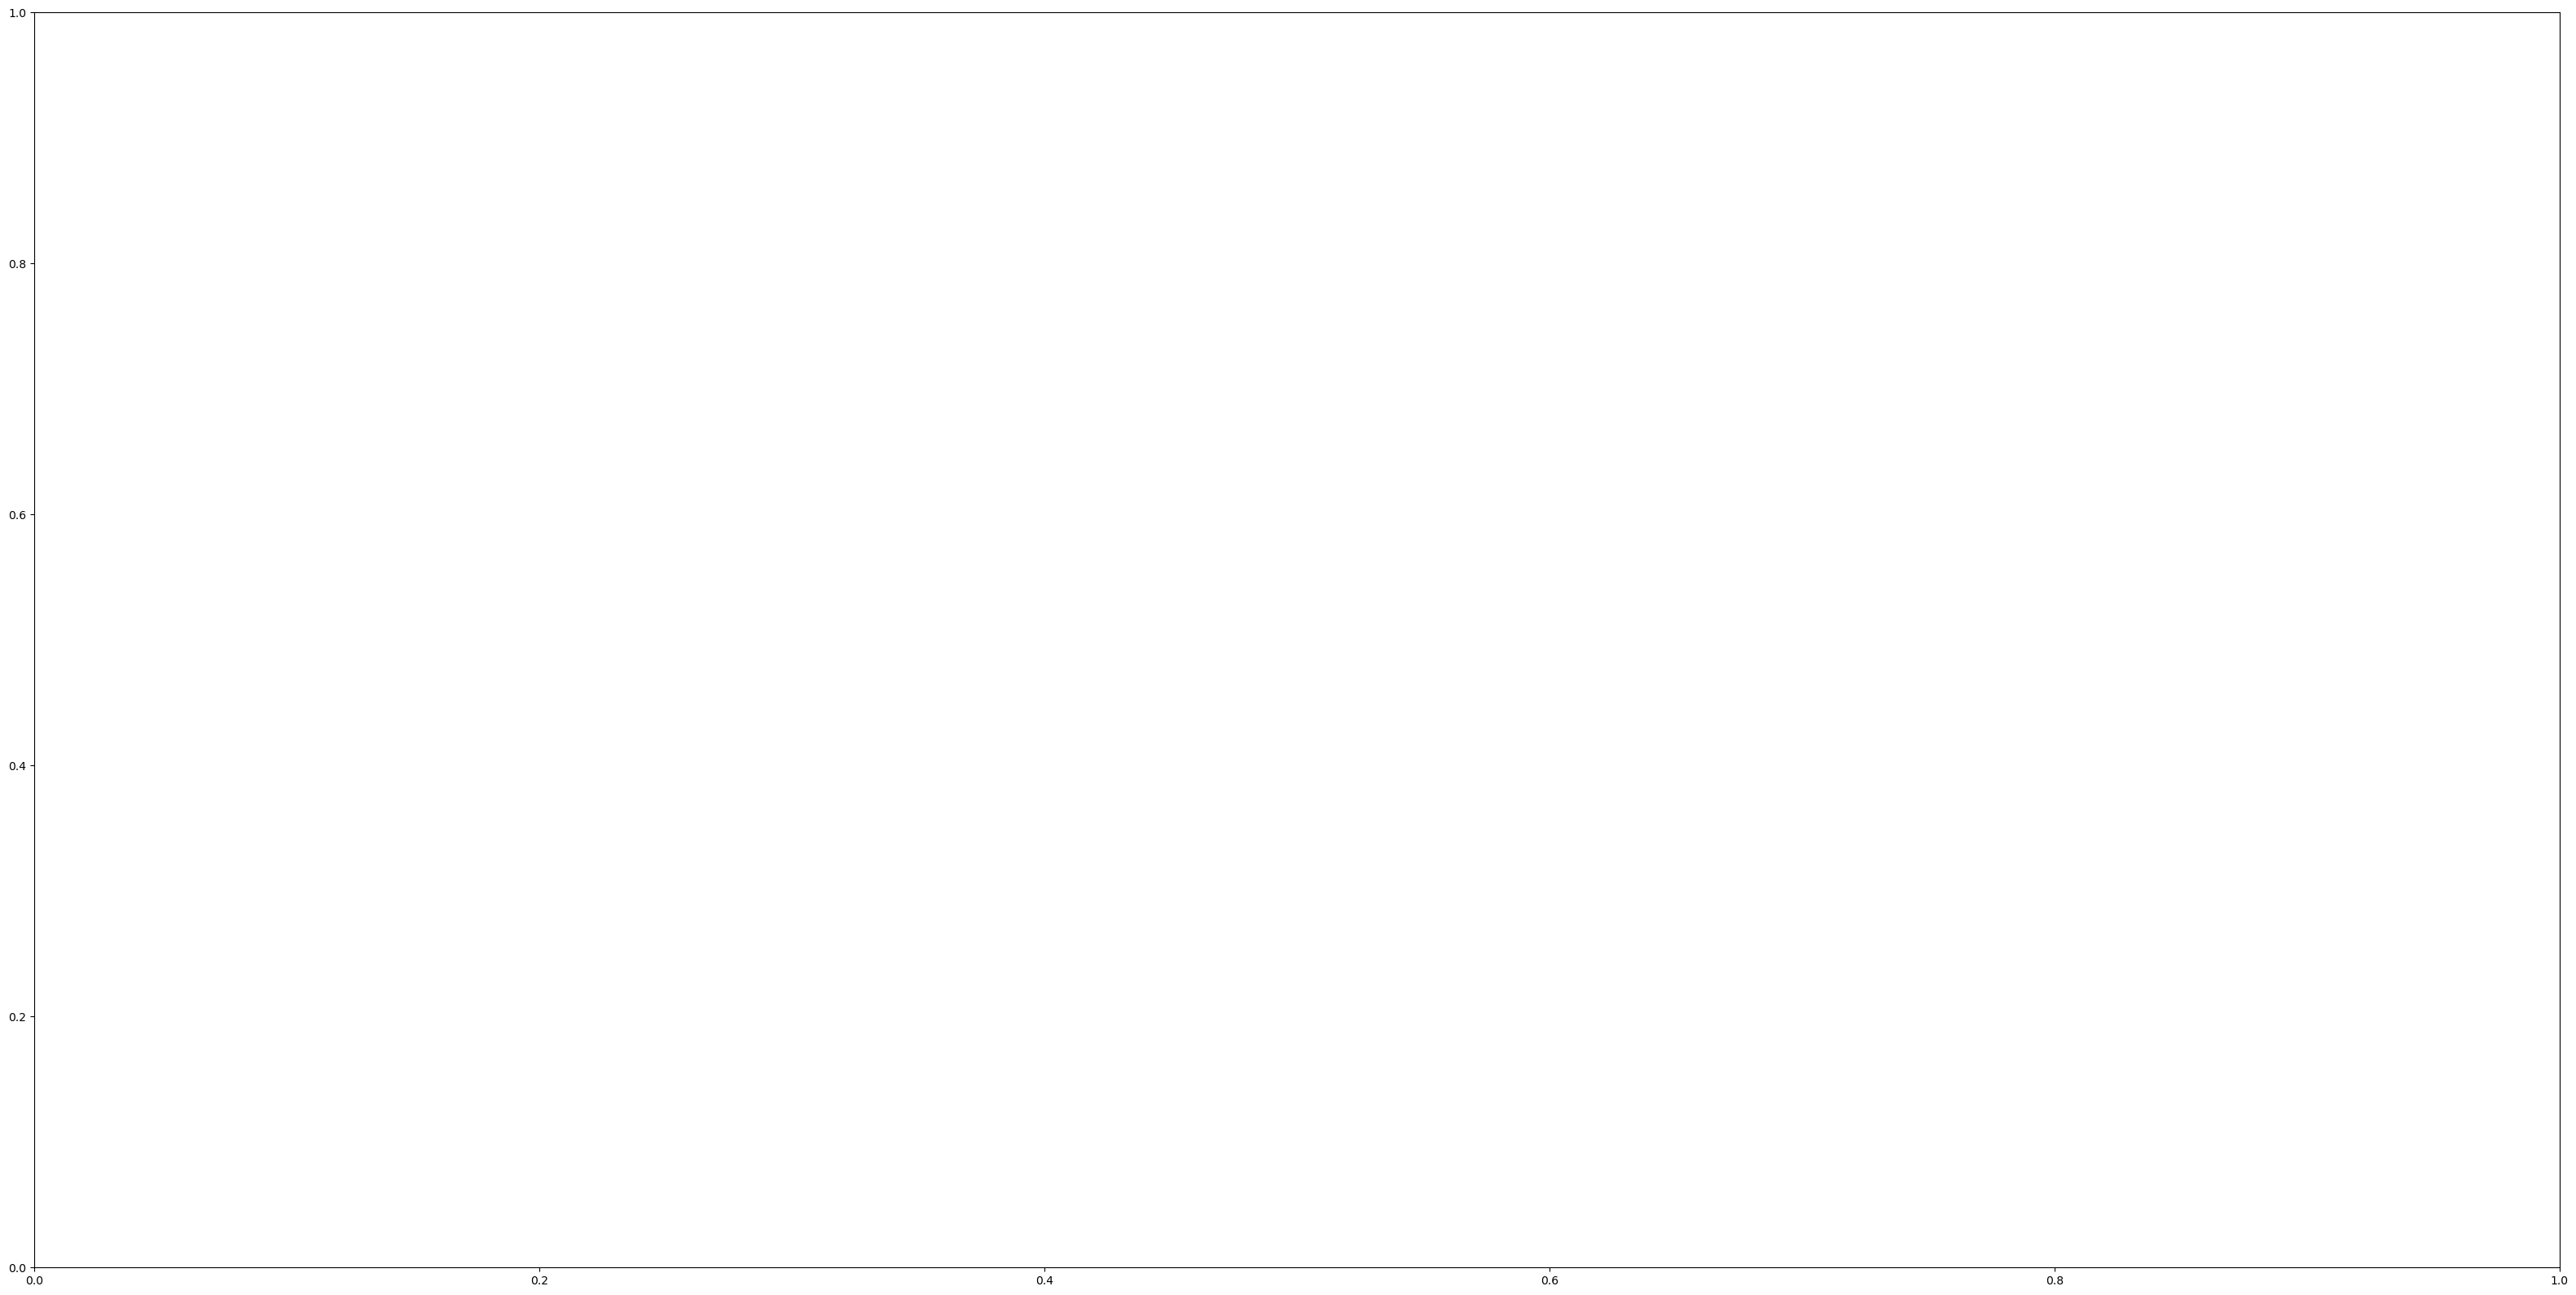

In [46]:
# Visualizing the tree

# now we have 50 estimators (trees), so let's pick the first one to visualize
e = rf.estimators_[0]

from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = x_train.columns, fontsize=15, ax = ax)

In [ ]:
# col2 = top_n.index.tolist()
# xvars = col2
# # xvars.remove('ESN')
# yvar = 'ESN'

# df_to_fit = cluster_2017_final[xvars+[yvar]].dropna()

# rf, x_train = training_model(xvars, yvar, df_to_fit)

In [ ]:
# Training model functions 
# Training the Model with 2017 data set 
# we implement a train-text model within here to understand how well the model is performing with respect to the 2017 (known) data

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


# declaring all variables but ESN as x variables value

def modelperformance(modelname, y_pred, y_test):
    print("\n", "------------------- ", modelname, "Performance -------------------","\n")
    print('Accuracy Score = ',accuracy_score(y_test, y_pred))  
    print("\n", 'Confusion Matrix')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


def training_model(xvars, yvar, df_to_fit):

    X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_split(df_to_fit[xvars], 
                                                                            df_to_fit[yvar], 
                                                                            test_size = 0.25, 
                                                                            random_state = 1)

    # random forest classification and prediction
    from sklearn.ensemble import RandomForestClassifier 

    rf = RandomForestClassifier(n_estimators = 50, random_state = 1)
    # rf = DecisionTreeClassifier(random_state = 1)

    # now fit the model
    rf.fit(X_train_2017, y_train_2017)

    print("\n", "------------------- Model Trained Successfully -------------------","\n")
    
    # predicting the target variable
    y_pred_2017 = rf.predict(X_test_2017)

    print('2017 Training Model: Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred_2017.mean(), y_pred_2017.mean()), "\n")
    modelperformance("Training model", y_pred_2017, y_pred_2017)
    return (rf, X_train_2017)

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer()

# Define the feature variables and the target variable
X_2017 = final_df_2017[[
       'total pop', 'white', 'black', 'native', 'asian',
       'hawaiian/pac islander', 'median_hh_income', 'vehicles_avail',
       'LATITUDE', 'LONGITUDE', 'ACCESSIBILITYMASK']]
y_2017 = final_df_2017['ESN']

X_2019 = final_df_2019[[
       'total pop', 'white', 'black', 'native', 'asian',
       'hawaiian/pac islander', 'median_hh_income', 'vehicles_avail',
       'LATITUDE', 'LONGITUDE', 'ACCESSIBILITYMASK']]
y_2019 = final_df_2019['ESN']

# Initialize the imputer

# Impute the missing values in X_2017 and X_2019
X_2017 = imputer.fit_transform(X_2017)
X_2019 = imputer.transform(X_2019)

# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the 2017 data
rfc.fit(X_2017, y_2017)

# Predict the 'ESN' variable for the 2017 and 2019 data
y_pred_2017 = rfc.predict(X_2017)
y_pred_2019 = rfc.predict(X_2019)



# Print the classification report for the 2017 and 2019 predictions
print('Classification Report 2017:')
print(classification_report(y_2017, y_pred_2017))
print('\nClassification Report 2019:')
print(classification_report(y_2019, y_pred_2019))

# Print the confusion matrix for the 2017 and 2019 predictions
print('Confusion Matrix 2017:')
print(confusion_matrix(y_2017, y_pred_2017))
print('\nConfusion Matrix 2019:')
print(confusion_matrix(y_2019, y_pred_2019))

# Print the accuracy score for the 2017 and 2019 predictions
print('Accuracy Score 2017:')
print(accuracy_score(y_2017, y_pred_2017))
print('\nAccuracy Score 2019:')
print(accuracy_score(y_2019, y_pred_2019))


Classification Report 2017:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2723
           1       1.00      1.00      1.00       550

    accuracy                           1.00      3273
   macro avg       1.00      1.00      1.00      3273
weighted avg       1.00      1.00      1.00      3273


Classification Report 2019:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2723
           1       1.00      0.84      0.91       550

    accuracy                           0.97      3273
   macro avg       0.98      0.92      0.95      3273
weighted avg       0.97      0.97      0.97      3273

Confusion Matrix 2017:
[[2723    0]
 [   0  550]]

Confusion Matrix 2019:
[[2723    0]
 [  88  462]]
Accuracy Score 2017:
1.0

Accuracy Score 2019:
0.973113351665139
